# 1141ML Final - DSM 2D

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")
sigma_dsm=1.2
batch_size=2048


In [ ]:
def sample_noisy_x_2d(batch_size, sigma):

    mu1 = np.array([-5, 0], dtype=np.float32)
    mu2 = np.array([ 3, 0], dtype=np.float32)
    w = np.random.rand(batch_size) < 0.5
    x = np.zeros((batch_size, 2), dtype=np.float32)

    x[w]  = mu1 + np.random.randn(w.sum(),  2).astype(np.float32)
    x[~w] = mu2 + np.random.randn((~w).sum(), 2).astype(np.float32)
    eps = np.random.randn(batch_size, 2).astype(np.float32)
    x_tilde = x + sigma * eps

    return x_tilde, eps


In [ ]:
class ScoreNet(nn.Module):
    def __init__(self, x_dim, hidden, num_layers):
        super().__init__()

        layers = [nn.Linear(x_dim, hidden), nn.SiLU()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(hidden, x_dim))  # output same dimension

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = ScoreNet(x_dim=2, hidden=128, num_layers=4).to(device)


In [ ]:
def dsm_loss_step_2d():
    x_tilde_np, eps_np = sample_noisy_x_2d(batch_size, sigma_dsm)

    x_tilde = torch.from_numpy(x_tilde_np).to(device)
    eps     = torch.from_numpy(eps_np).to(device)

    s_hat = model(x_tilde)

    target = -eps / sigma_dsm

    loss = ((s_hat - target)**2).mean()
    return loss


In [ ]:
#### Training Loop
num_steps=5000
lr=5e-4

optimizer=optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,      
    patience=200,     
    verbose=True
)
loss_history = []

for step in range(1, num_steps+1):
    model.train()

    loss = dsm_loss_step_2d()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    loss_history.append(loss.item())

    if step % 200 == 0:
        print(f"step {step:4d} | loss = {loss.item():.6f} | lr = {lr:.6f}")


c:\Users\user\.conda\envs\ml_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


step  200 | loss = 0.317552 | lr = 0.000500
step  400 | loss = 0.308811 | lr = 0.000500
step  600 | loss = 0.297831 | lr = 0.000500
step  800 | loss = 0.302682 | lr = 0.000500
step 1000 | loss = 0.313807 | lr = 0.000500
step 1200 | loss = 0.318921 | lr = 0.000500
step 1400 | loss = 0.299880 | lr = 0.000500
step 1600 | loss = 0.300708 | lr = 0.000500
step 1800 | loss = 0.304160 | lr = 0.000500
step 2000 | loss = 0.305048 | lr = 0.000500
step 2200 | loss = 0.308219 | lr = 0.000500
step 2400 | loss = 0.300775 | lr = 0.000500
step 2600 | loss = 0.305812 | lr = 0.000500
step 2800 | loss = 0.315262 | lr = 0.000500
step 3000 | loss = 0.307570 | lr = 0.000500
step 3200 | loss = 0.288597 | lr = 0.000500
step 3400 | loss = 0.326768 | lr = 0.000500
step 3600 | loss = 0.295156 | lr = 0.000500
step 3800 | loss = 0.310339 | lr = 0.000500
step 4000 | loss = 0.305447 | lr = 0.000500
step 4200 | loss = 0.308882 | lr = 0.000500
step 4400 | loss = 0.314438 | lr = 0.000500
step 4600 | loss = 0.297850 | lr

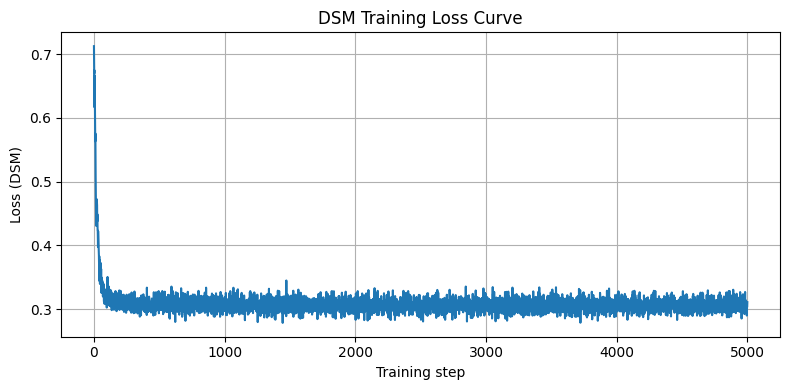

In [92]:

def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_curve(loss_history)

In [93]:
print(sigma_dsm)

1.2


## 2D Langevin Sampling

In [94]:
def langevin_sampling_2d(model, steps=3000, eta=0.002):
    model.eval()
    x = torch.randn(5000, 2).to(device)
    eta = 0.002 / (sigma_dsm**2)
    sqrt_term = torch.sqrt(torch.tensor(2*eta, device=device))

    for _ in range(steps):
        with torch.no_grad():
            score = model(x)
            noise = torch.randn_like(x)
            x = x + eta * score + sqrt_term * noise

    return x.detach().cpu().numpy()


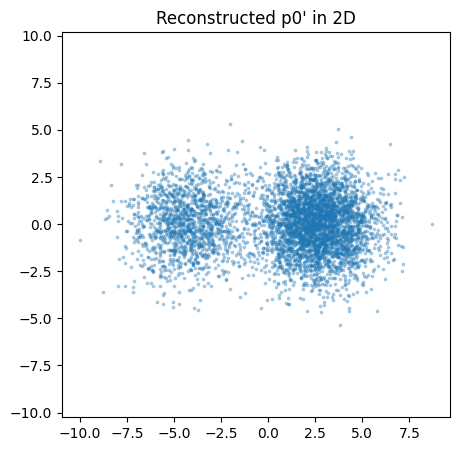

In [95]:
samples = langevin_sampling_2d(model)

plt.figure(figsize=(5,5))
plt.scatter(samples[:,0], samples[:,1], s=3, alpha=0.3)
plt.title("Reconstructed p0' in 2D")
plt.axis("equal")
plt.show()


## p0 -> pT -> p0'

In [ ]:
def forward_backward_process_2d(model, sigma, steps, eta, N_total):
    # ========== Forward: p0 -> pT ==========
    mu1 = np.array([-5, 0], dtype=np.float32)
    mu2 = np.array([ 3, 0], dtype=np.float32)
    w = np.random.rand(N_total) < 0.5
    x0 = np.zeros((N_total, 2), dtype=np.float32)
    x0[w]  = mu1 + np.random.randn(w.sum(), 2).astype(np.float32)
    x0[~w] = mu2 + np.random.randn((~w).sum(), 2).astype(np.float32)

    eps = np.random.randn(N_total, 2).astype(np.float32)
    xT = x0 + sigma * eps

    # ========== Backward: xT -> x0' via Langevin ==========
    x = torch.from_numpy(xT).to(device)
    sqrt_term = torch.sqrt(torch.tensor(2*eta, device=device))

    with torch.no_grad():
        for _ in range(steps):
            score = model(x)
            noise = torch.randn_like(x)
            x = x + eta * score + sqrt_term * noise

    x0p = x.detach().cpu().numpy()

    return x0, xT, x0p


In [ ]:
def plot_forward_backward_2d(x0, xT, x0p):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    # p0(x)
    axs[0].scatter(x0[:,0], x0[:,1], s=5, alpha=0.3)
    axs[0].set_title("Original $p_0(x)$")
    axs[0].set_aspect('equal')

    # pT(x)
    axs[1].scatter(xT[:,0], xT[:,1], s=5, alpha=0.3, color='orange')
    axs[1].set_title("Noisy distribution $p_T(x)$")
    axs[1].set_aspect('equal')

    # p0'(x)
    axs[2].scatter(x0p[:,0], x0p[:,1], s=5, alpha=0.3, color='steelblue')
    axs[2].set_title("Reconstructed $p_0'(x)$")
    axs[2].set_aspect('equal')

    plt.tight_layout()
    plt.show()


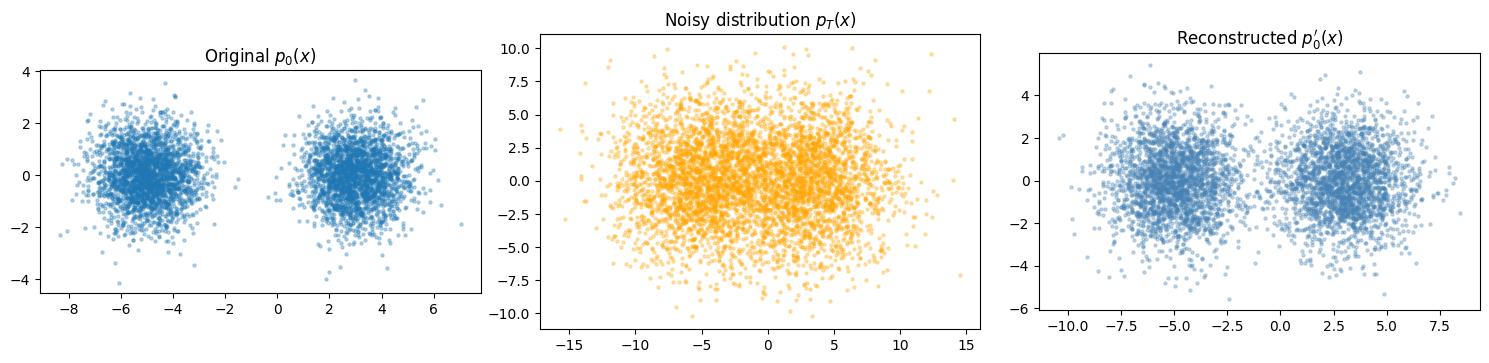

In [ ]:
x0, xT, x0p = forward_backward_process_2d(
    model,
    sigma=3,    
    steps=3000,
    eta=0.002,
    N_total=5000
)

plot_forward_backward_2d(x0, xT, x0p)
